In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import datetime
import tensorflow_hub as hub
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Encipher/train2.csv')

In [ ]:
df.columns
#Filling all missing values with 0
df = df.fillna('Other')

In [ ]:
# 20% is test size and 80% is train size
X_train, X_test = train_test_split(df, test_size=0.2, random_state=111)

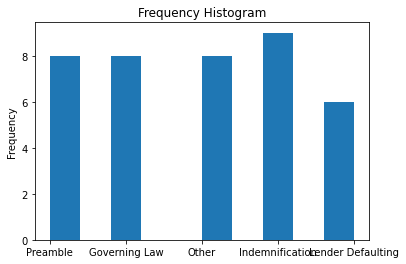

In [ ]:
# Counting no of agreements of different types and plotting
import matplotlib.pyplot as plt

df['Type'].value_counts()
plt.hist(df['Type'], bins=10)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [ ]:
from sklearn.utils import class_weight
# Computing class weights using 'balance' as method and passing target column as Type
class_weights = list(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(df['Type']),y = df['Type']))

In [ ]:
# Classes which are in higher number will be assigned lower weights and vice versa
class_weights.sort()
class_weights

[0.8666666666666667, 0.975, 0.975, 0.975, 1.3]

In [ ]:
# As keras model expects weights as a dictionary object, so converting list to dictionary
weights = {}
for index, weight in enumerate(class_weights):
  weights[index] = weight
weights

{0: 0.8666666666666667, 1: 0.975, 2: 0.975, 3: 0.975, 4: 1.3}

In [ ]:
# Dataset from pandas is converted to tensorflow tensor
dataset_train = tf.data.Dataset.from_tensor_slices((X_train['Agreement'].values, X_train['Type'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test['Agreement'].values, X_test['Type'].values))

In [ ]:
# Printing dataset in batch of 5 (for train data)
for text, target in dataset_train.take(5):
  print('Complaint: {}, Target: {}'.format(text, target))

Complaint: b'\xe2\x80\x9cAcceptance Condition\xe2\x80\x9d means the condition with respect to the number of acceptances to the Offer which must be secured to declare the Offer unconditional as to acceptances which shall not be less than 90% of the Target Shares to which the Offer relates.', Target: b'Other'
Complaint: b'The Borrower shall indemnify all parties, and each Related Party of any of the foregoing Persons (each such Person being called an \xe2\x80\x9cIndemnitee\xe2\x80\x9d) against, and hold each Indemnitee harmless from, any and all losses, claims, damages, liabilities and related expenses', Target: b'Indemnification'
Complaint: b'This agreement is dated 22 December 2014 and made between Parties XYZ Gold Mining Company Limited, The Subsidiaries of the Borrower listed in Part I of Schedule 1 as original guarantors, Absa Bank Limited and Nedbank Limited as coordinators, The Financial Institutions listed in Part II of Schedule 1 as mandated lead arrangers and lenders and Nedban

In [ ]:
# Printing test data
for text, target in dataset_test.take(5):
  print('Complaint: {}, Target: {}'.format(text, target))

Complaint: b'This agreement is dated 22 December 2014 and made between Parties XYZ Gold Mining Company Limited, The Subsidiaries of the Borrower listed in Part I of Schedule 1 as original guarantors, Absa Bank Limited and Nedbank Limited as coordinators, The Financial Institutions listed in Part II of Schedule 1 as mandated lead arrangers and lenders and Nedbank Limited as agent of the other Finance Parties', Target: b'Preamble'
Complaint: b'\xe2\x80\x9cApplicable Rate\xe2\x80\x9d means, the following percentages per annum, based upon the Consolidated Leverage Ratio as set forth in the most recent Compliance Certificate received by the Administrative Agent', Target: b'Other'
Complaint: b'The Borrower shall indemnify all parties, and each Related Party of any of the foregoing Persons (each such Person being called an \xe2\x80\x9cIndemnitee\xe2\x80\x9d) against, and hold each Indemnitee harmless from, any and all losses, claims, damages, liabilities and related expenses', Target: b'Indem

In [ ]:
# To convert target column into numerical representation
table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant(['Preamble', 'Other', 'Indemnification', 'Governing Law', 'Lender Defaulting']),
        values = tf.constant([0, 1, 2, 3, 4])
    ),
    default_value = tf.constant(-1),
    name = "target_encoding"
)

# Tensorflow function to do table lookup()Ex. for Preamble it will return 0
def target(x):
  return table.lookup(x)

In [ ]:
# Function to see how data looks like
def show_batch(dataset, size = 5):
  for batch, label in dataset.take(size):
    print(batch.numpy())
    # Here it will call target function and return integer
    print(target(label).numpy())

In [ ]:
show_batch(dataset_test, 5)

b'This agreement is dated 22 December 2014 and made between Parties XYZ Gold Mining Company Limited, The Subsidiaries of the Borrower listed in Part I of Schedule 1 as original guarantors, Absa Bank Limited and Nedbank Limited as coordinators, The Financial Institutions listed in Part II of Schedule 1 as mandated lead arrangers and lenders and Nedbank Limited as agent of the other Finance Parties'
0
b'\xe2\x80\x9cApplicable Rate\xe2\x80\x9d means, the following percentages per annum, based upon the Consolidated Leverage Ratio as set forth in the most recent Compliance Certificate received by the Administrative Agent'
1
b'The Borrower shall indemnify all parties, and each Related Party of any of the foregoing Persons (each such Person being called an \xe2\x80\x9cIndemnitee\xe2\x80\x9d) against, and hold each Indemnitee harmless from, any and all losses, claims, damages, liabilities and related expenses'
2
b'This agreement and other loan documents shall be governed by and in adherence wi

In [ ]:
# One-hot encoding value of target
def fetch(text, labels):
  return text, tf.one_hot(target(labels),5)

In [ ]:
# In train and test data, target c0lumn are going to get converted into numerical and one hot encoded
train_data_f = dataset_train.map(fetch)
test_data_f = dataset_test.map(fetch)

In [ ]:
# Printing value in batch of 5, (print batched tensor value)
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'\xe2\x80\x9cAcceptance Condition\xe2\x80\x9d means the condition with respect to the number of acceptances to the Offer which must be secured to declare the Offer unconditional as to acceptances which shall not be less than 90% of the Target Shares to which the Offer relates.',
        b'The Borrower shall indemnify all parties, and each Related Party of any of the foregoing Persons (each such Person being called an \xe2\x80\x9cIndemnitee\xe2\x80\x9d) against, and hold each Indemnitee harmless from, any and all losses, claims, damages, liabilities and related expenses',
        b'This agreement is dated 22 December 2014 and made between Parties XYZ Gold Mining Company Limited, The Subsidiaries of the Borrower listed in Part I of Schedule 1 as original guarantors, Absa Bank Limited and Nedbank Limited as coordinators, The Financial Institutions listed in Part II of Schedule 1 as mandated lead arrangers and lenders and Nedbank Limit

In [ ]:
# Creating a embedding layer, taking pretrained embedding from tensorflow
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 9.05634582e-01,  8.44805017e-02,  9.75493640e-02,
         1.22876972e-01,  6.86208680e-02,  8.90760198e-02,
        -3.17467079e-02,  1.51430488e-01,  3.77125777e-02,
         8.19774419e-02,  1.95255429e-01,  9.77621600e-02,
         8.51709172e-02, -8.41268077e-02, -9.39441845e-03,
        -4.68816273e-02, -1.45099953e-01,  1.31754339e-01,
        -2.11709186e-01,  7.56165981e-01,  1.86482057e-01,
         1.15941636e-01, -9.06292349e-02,  3.03071309e-02,
         2.64328886e-02,  1.78374544e-01, -7.82951787e-02,
         4.42925617e-02, -1.93234488e-01, -5.12457045e-04,
         1.38617024e-01, -5.50562032e-02,  4.34877723e-02,
        -1.72113910e-01, -1.37691736e-01,  1.46489516e-01,
        -1.72132820e-01, -9.21033695e-02, -1.46835268e-01,
         6.45596161e-02,  1.87525339e-02,  4.62956121e-03,
        -1.37142912e-01, -2.82380402e-01,  5.30879013e-02,
         6.41505495e-02,  7.77157769e-02, -5.26625551e-02,
      

In [ ]:
# Creating the keras sequential model
model = tf.keras.Sequential()
# Adding the embedding layer to model
model.add(hub_layer)
# Adding 128, 128, 64, 32- 4 hidden layer
for units in [128, 128, 64, 32]:
  model.add(tf.keras.layers.Dense(units, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.3))
# Adding output layer, 5 classes
model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)               

In [ ]:
# Compiling the model, giving metrics as accuracy
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Shuffling the training data and batching it
train_data_f=train_data_f.shuffle(70).batch(5)
test_data_f=test_data_f.batch(5)

In [ ]:
# Training the data - 16 epochs
history=model.fit(train_data_f,
                  epochs=16,
                  validation_data=test_data_f,
                  verbose=1,
                  class_weight=weights)

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 11s 1s/step - loss: 1.6677 - accuracy: 0.1935 - val_loss: 1.5484 - val_accuracy: 0.5000
Epoch 2/16
7/7 [==============================] - 9s 1s/step - loss: 1.6228 - accuracy: 0.2258 - val_loss: 1.5489 - val_accuracy: 0.5000
Epoch 3/16
7/7 [==============================] - 9s 1s/step - loss: 1.5904 - accuracy: 0.2581 - val_loss: 1.5213 - val_accuracy: 0.7500
Epoch 4/16
7/7 [==============================] - 9s 1s/step - loss: 1.6067 - accuracy: 0.2258 - val_loss: 1.5009 - val_accuracy: 0.8750
Epoch 5/16
7/7 [==============================] - 9s 1s/step - loss: 1.4906 - accuracy: 0.5806 - val_loss: 1.4642 - val_accuracy: 0.8750
Epoch 6/16
7/7 [==============================] - 9s 1s/step - loss: 1.4800 - accuracy: 0.4194 - val_loss: 1.4243 - val_accuracy: 0.7500
Epoch 7/16
7/7 [==============================] - 9s 1s/step - loss: 1.4565 - accuracy: 0.5484 - val_loss: 1.3518 - val_accuracy: 0.7500
Epoch 8/16
7/7 [==============================] - 9

In [ ]:
# Printing results of the model
results = model.evaluate(dataset_test.map(fetch).batch(11491), verbose = 2)
print(results)

1/1 - 0s - loss: 0.4625 - accuracy: 0.8750 - 176ms/epoch - 176ms/step
[0.4625293016433716, 0.875]


In [ ]:
# Working with test data - for predictions
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(8)))
test_data, test_labels

(<tf.Tensor: shape=(8,), dtype=string, numpy=
 array([b'This agreement is dated 22 December 2014 and made between Parties XYZ Gold Mining Company Limited, The Subsidiaries of the Borrower listed in Part I of Schedule 1 as original guarantors, Absa Bank Limited and Nedbank Limited as coordinators, The Financial Institutions listed in Part II of Schedule 1 as mandated lead arrangers and lenders and Nedbank Limited as agent of the other Finance Parties',
        b'\xe2\x80\x9cApplicable Rate\xe2\x80\x9d means, the following percentages per annum, based upon the Consolidated Leverage Ratio as set forth in the most recent Compliance Certificate received by the Administrative Agent',
        b'The Borrower shall indemnify all parties, and each Related Party of any of the foregoing Persons (each such Person being called an \xe2\x80\x9cIndemnitee\xe2\x80\x9d) against, and hold each Indemnitee harmless from, any and all losses, claims, damages, liabilities and related expenses',
        b'This 

In [ ]:
y_pred=model.predict(test_data)
y_pred

array([[9.1167969e-01, 2.5686121e-03, 8.4152430e-02, 5.3146924e-04,
        1.0679412e-03],
       [3.2707900e-02, 4.2400700e-01, 5.1019926e-02, 1.6539334e-01,
        3.2687181e-01],
       [5.5188742e-02, 1.7293198e-03, 9.4102991e-01, 9.4560388e-04,
        1.1064311e-03],
       [3.7733510e-02, 1.4422439e-01, 6.0924113e-02, 5.8182353e-01,
        1.7529444e-01],
       [8.9942753e-01, 3.9142147e-03, 9.4879486e-02, 6.8498123e-04,
        1.0937912e-03],
       [2.1037427e-01, 6.7310794e-03, 7.7576655e-01, 2.0217095e-03,
        5.1064566e-03],
       [6.1757665e-02, 8.0382554e-03, 9.2017359e-01, 3.9253435e-03,
        6.1050579e-03],
       [2.8617071e-02, 1.8189955e-01, 7.9577215e-02, 2.3585679e-01,
        4.7404933e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         0

    accuracy                           0.88         8
   macro avg       0.80      0.70      0.73         8
weighted avg       1.00      0.88      0.92         8



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1))

array([[2, 0, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Encipher/test.csv')
test_data

,Id,Agreement
0,1,"Amendment No. 1 dated as of February 4, 2016 (..."
1,2,"Subject to the Legal Reservations, (a) the cho..."
2,3,"This Agreement, and any non-contractual obliga..."
3,4,Each Lender agrees to indemnify the Administra...
4,5,Any Lender that (a) has failed to (i) fund all...
5,6,This Assignment and Assumption shall be govern...
6,7,As soon as practicable after any payment of In...
7,8,"Non-Defaulting Lender means, at any time, each..."
8,9,Fundco Facility Agreement means the facility a...
9,10,Notwithstanding any provision of this Agreemen...


In [ ]:
sample_to_predict = np.array(test_data['Agreement'])

In [ ]:
predictions = model.predict(sample_to_predict)
print(predictions)

[[0.8618604  0.00992487 0.12133747 0.00254627 0.00433098]
 [0.03849408 0.14648205 0.07644214 0.51242864 0.22615305]
 [0.05927369 0.16028744 0.13138396 0.41000006 0.23905486]
 [0.0656912  0.01938979 0.8879934  0.01247724 0.01444835]
 [0.01461334 0.10795821 0.05212627 0.07214797 0.75315416]
 [0.06447008 0.16872042 0.11722296 0.4432552  0.20633137]
 [0.02629248 0.15019293 0.10179945 0.08475128 0.6369639 ]
 [0.06024925 0.15830366 0.09414171 0.1144966  0.57280874]
 [0.37733695 0.09913436 0.36272058 0.08413789 0.07667019]
 [0.01604292 0.11441586 0.03776681 0.08102727 0.7507471 ]]


In [ ]:
labels = ['Preamble', 'Other', 'Indemnification', 'Governing Law', 'Lender Defaulting']

In [ ]:
myDict = {}
for i in range(len(test_data['Agreement'])):
  confidenceScore = {}
  for j in range(5):
    confidenceScore[labels[j]] = predictions[i][j]
  myDict[i] = {'Agreement': test_data['Agreement'][i], 'Prediction': labels[int(np.argmax(predictions[i]))], 'Confidence': confidenceScore}

In [ ]:
import json

In [ ]:
print(myDict)
out_file = open("/content/drive/MyDrive/Encipher/predictions.json", "w") 
    
json.dump(str(myDict), out_file, indent = 6) 
    
out_file.close() 

{0: {'Agreement': 'Amendment No. 1 dated as of February 4, 2016 (this “Amendment No. 1”), to the Amendment and Restatement Agreement dated as of January 10, 2016 (the “Existing Restatement Agreement”), among GGG HOLDING (U.S.) INC., (the “Borrower”), CGG, a societe anonyme incorporated under the laws of France (“Parent”), the LENDERS from time to time party thereto and SUISSE AG, as Administrative Agent for the Lenders (in such capacity, “Administrative Agent”) and as Collateral Agent (“Collateral Agent”) for the Lenders.', 'Prediction': 'Preamble', 'Confidence': {'Preamble': 0.8618604, 'Other': 0.009924872, 'Indemnification': 0.12133747, 'Governing Law': 0.0025462722, 'Lender Defaulting': 0.0043309773}}, 1: {'Agreement': 'Subject to the Legal Reservations, (a) the choice of law specified in eachFinance Document as the governing law of such Finance Document will be recognized and enforced in its Relevant Jurisdictions and(b) any judgment obtained in New York (or in the jurisdiction of 